# Plotting Multiple Time Series and Visualizing Ensemble Spread
## **CodeAlong Version**
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Load and Query the CMIP6 AWS Catalog](#load)

[Read in Data as an Xarray Object](#xarray)

[Plot Time Series](#time_series)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will be reading in the database of Coupled Model Intercomparison Project phase 6 (CMIP6) output hosted by Amazon Web Services and exploring its contents. 

The steps in this tutorial build on the skills we learned in previous tutorials:
- [Read in Data and Plot a Time Series](https://github.com/climate-datalab/Time-Series-Plots/blob/main/1.%20Read%20in%20Climate%20Data%20%2B%20Plot%20a%20Regionally%20Averaged%20Time%20Series.ipynb)
  (regional averaging, time series plotting)
- [Opening and Querying the CMIP6 AWS Database](https://github.com/climate-datalab/CMIP6_AWS/blob/main/1.%20Opening%20and%20Querying%20the%20CMIP6%20Catalog.ipynb)  (data access via Amazon Web Services)

Basically: we'll be doing a lot of the same things we did in those tutorials, but this time extending the plots to include information from multiple _ensemble members_ and multiple climate models! Please refer back to those materials if you would like additional detail.

### **This is the Code-Along version of tutorial 1!!** 

This notebook contains only a selected subset of the code for tutorial 1, so that it can be completed in a "code along" format in a classroom context. If you would like the fully completed version, please see "1. Plotting Multiple Ensemble Members.ipynb" in this repo.

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes you're starting with an environment in which `intake`, `intake-esm`, and `s3fs` are already installed - for details on those packages, see the [CMIP6 AWS repo](https://github.com/climate-datalab/CMIP6_AWS)!

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs

<a id='load'></a> 
## **Load and Query the CMIP6 AWS Catalog**

As we did in previous tutorials, we'll load the CMIP6 database hosted by Amazon Web Services. More detail on that database is available on the [Amazon Registry of Open Data](https://registry.opendata.aws/cmip6/).


We first begin with opening the data catalog itself (_note - this step can be fairly slow on some machines_):

In [3]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

Now, let's do some more sophisticated analysis! Rather than pulling down information from a single simulation, we'll aim to gather all of the _ensemble members_ for two different climate models. 

#### **What is an ensemble member??**

This is a term we've thrown around in a couple of tutorials now - let's dig in and think about it a little more!

The broad definition of an ensemble member is: **a single simulation run with a given climate model, for a given configuration**, where "configuration" here means that you've set the model up in a particular way (for instance: to run a simulation of the historical period, or for a specific future scenario). The _difference between ensemble members is ONLY that they have slightly different INITIAL CONDITIONS_ - everything else is the same!

Here is a schematic example showing how you can think of ensemble members: since they begin in slightly different places, their _time evolution_ will be a little different (think differences between weather forecasts). But the background effects of _forced_ changes to the climate system will be the same in all members (since they set up all the members exactly the same way); so by averaging together all the different ensemble members, you can get a really good estimate of the total changes due to, for instance, climate change!

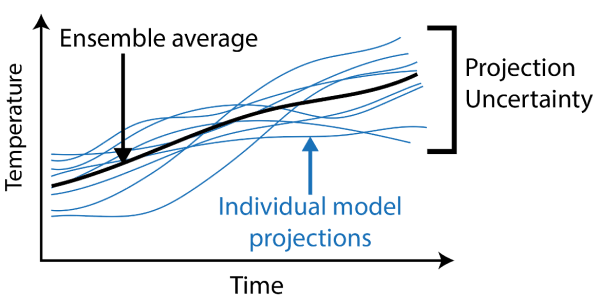



Let's display data from a couple of members of a single ensemble, to get a better idea of how that works. We'll start with picking a model, the Community Earth System Model version 2 (CESM2) - let's begin with the historical information, to make things simpler.

Set the following fields to extract this information from the CMIP6 catalog:

- **activity_id**: here we want "CMIP" since that's where the historical simulations live

- **source_id**: this is the name of the model, so "CESM2"

- **experiment_id**: the type of simulation we want, here "historical"

- **table_id**: the category of output variable we're looking for. For surface air temperature, this will be in the atmosphere, and we'll pull out monthly data to make the files smaller: that means the "Amon" table is what we want!

- **variable_id**: the actual name of the variable, here "tas"

In [4]:
# Specify search terms to query catalog 
# activity_id: which project do you want? CMIP = historical data
activity_ids = ['CMIP'] 

# source_id: which model do you want? Let's say CESM2
source_id = ['CESM2']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical']

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = ['Amon'] 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = ['tas'] 

As we did in tutorial 1, we now apply the `.search` functionality to retrieve the information we want, then convert it to a data frame that we can work with:

In [5]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
7,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
8,CMIP,NCAR,CESM2,historical,r7i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


Looking at the data frame displayed above, you might notice a couple of things. First: a lot of the entries seem nearly identical! That's good - after all, we're trying to get data from a SINGLE experiment with a SINGLE model.

The entries that show up as DIFFERENT between the data frame rows above are:

- **member_id**: this is where the names of the different ensemble members are stored. They will be things like "r10i1p1f1", "r16i1p1f1", etc. For more detail on how the member names work, you can refer back to the [Climate DataLab filename decoder](https://climate-datalab.org/filename-decoder/).

- **zstore**: this is the location of a given ensemble member on the remote server (in this case, Amazon Web Services cloud hosting). This is what you'll need to refer to in order to load the data into local memory as an xarray object!

<a id='xarray'></a> 
## **Read in Data as an Xarray Object**

Now we can read in the zarr stores containing the actual information. I'm going to do this in a few steps, which might seem a bit complicated at first but will make it easier to work with the data once it's read in!


**1) Define an empty list**

First, we define an empty object that can be used to store the set of data from all of our ensemble members.

**2) Loop over all entries in the data frame**

Now we loop over all the entries in the data frame, so that we can read each of these in as individual xarray objects. Here I have retrieved the total number of entries first, using the `.shape` command applied to the data frame: the dimension of the data frame is \[number of data entries\] x \[number of data columns\], so we want the first value output by `.shape`. 

To get the loop to step through the data frame, I use the `range` command: this creates a range of integers starting with 0 and ending with one less than the value you give it. So `range(10)` will give you the integers from 0 to 9, and so on.

**3) Store data from each entry as xarray, add to list**

Inside the loop, we next use `xr.open_zarr` to read in each individual entry as an xarray object. Note that we again have to specify that anonymous access is allowed using the syntax `storage_options={'anon': True}`. Each xarray object is then appended to the empty list we initialized before the loop began - now we have a list of xarray Datasets!

**4) Concatenate the list into a single xarray object**

After the loop finishes, we can convert the list of xarray Datasets into a new Dataset with an additional dimension, for which we can specify a new name. This is done via the xarray `.concat` method; I like to call the dimension "member" since it refers to ensemble members.

As a nice bonus, we can also store the names of the actual ensemble members as value of the new "member" coordinate - that way we can keep track of that information in case we need it later. This is done using the `.assign_coords` function within xarray!

In [11]:
# Define an empty list
ens_data = []

# Retrieve number of entries in the data frame
num = res.df.shape[0]

# Loop over all entries in the data frame
for mem in range(num):
    print(res.df.member_id[mem])
    temp_data = xr.open_zarr(res.df['zstore'][mem], storage_options = {'anon': True})
    ens_data.append(temp_data)
    
# Concatenate the list into a single xarray object
ens_data = xr.concat(ens_data, dim = "member")

# Store the actual member information as values of the new dimension
ens_data = ens_data.assign_coords(member = ("member", res.df.member_id))

r4i1p1f1
r6i1p1f1
r3i1p1f1
r1i1p1f1
r2i1p1f1
r5i1p1f1
r9i1p1f1
r8i1p1f1
r7i1p1f1
r10i1p1f1
r11i1p1f1


Let's take a look at the new xarray dataset to see what's inside. The code block below demonstrates that in addition to the existing "lat", "lon", and "time" coordinates, now there's a new one: "member". 

_note: there is also a fifth dimension, "nbnd". Don't worry too much about this one, it's there to keep track of the boundaries between time steps/spatial grid points, which only matters if you're trying to do very exact math - for us, we can just ignore it!_

In [13]:
# Look at the new dataset we've created
ens_data

<xarray.Dataset>
Dimensions:    (lat: 192, member: 11, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (member, lat, nbnd) float64 dask.array<chunksize=(1, 192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member     (member) object 'r4i1p1f1' 'r6i1p1f1' ... 'r10i1p1f1' 'r11i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  182500.0
    case_id:                18
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r4i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/ef376c2e-c83b-4e73-a770-010e28bb1776
    version_id:             v20190308

<a id='time_series'></a> 
## **Plot a Time Series**

Now that the data have been read in and nicely formatted, we can proceed with regional averaging and plotting of time series the same way we did in previous tutorials. The only difference is that now we'll have multiple time series to include on our plot!

Let's work with a new region, one that encompasses the state of California: note that the longitudes for the CESM2 grid range from 0-360, and to match that I'll use positive longitudes for the California box.

In [14]:
# Define lat/lon bounds appropriate for California
lat_min, lat_max = 32, 42
lon_min, lon_max = 235, 247

Now we can use the same approach that we applied in [previous tutorials](https://github.com/climate-datalab/Time-Series-Plots) to generate a weighted, regionally averaged time series.

### **Define logical mask, filter out data outside region**

The code block below creates a logical (True/False) mask with the same size as the CESM2 grid, then drops all data which fall outside that region.

In [17]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
CA_lat = (ens_data.lat >= lat_min) & (ens_data.lat <= lat_max)
CA_lon = (ens_data.lon >= lon_min) & (ens_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
CA_data = ens_data.where(CA_lat & CA_lon, drop = True)

# Print out the results 
print(CA_data)

<xarray.Dataset>
Dimensions:    (member: 11, time: 1980, lat: 11, lon: 10, nbnd: 2)
Coordinates:
  * lat        (lat) float64 32.51 33.46 34.4 35.34 ... 39.11 40.05 40.99 41.94
    lat_bnds   (member, lat, nbnd) float64 dask.array<chunksize=(1, 11, 2), meta=np.ndarray>
  * lon        (lon) float64 235.0 236.2 237.5 238.8 ... 242.5 243.8 245.0 246.2
    lon_bnds   (lon, nbnd) float32 234.4 235.6 235.6 236.9 ... 245.6 245.6 246.9
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member     (member) object 'r4i1p1f1' 'r6i1p1f1' ... 'r10i1p1f1' 'r11i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member, time, lat, lon) float32 dask.array<chunksize=(1, 600, 11, 10), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    bra

In the print statement above, you can see that the "member" dimension is still retained in the filtered data.

...or in other words: _you can grab the regional data for all ensemble members at the same time!_

### **Define area weights, calculate average over region**

Now we can proceed with averaging over our specified region. Since this is a pretty big area and fairly far from the equator, we'll also want to calculate _area weights_ for the grid boxes, following the same procedure we used [earlier](https://github.com/climate-datalab/Time-Series-Plots/blob/main/3.%20Weight%20Grid%20Cells%20%2B%20Plot%20Global%20Average.ipynb).

To make it easier to see the ensemble spread later on, as well as making it easier to work with the time dimension, let's also calculate the annual mean using `groupby`!

In [18]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [19]:
# Weight the data by grid box area
dat_weighted = weights(CA_data)

# Average over lat, lon
dat_wgtmn = dat_weighted.mean(dim = ['lat', 'lon'])

# Calculate annual mean
dat_wgtmn = dat_wgtmn.groupby('time.year').mean()

In [20]:
# Display time coordinate: now it's called year
print(dat_wgtmn.year)

<xarray.DataArray 'year' (year: 165)>
array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873,
       1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897,
       1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1

### **Make the plot**

Now the data should finally be in shape to put onto a time series plot! We can use most of the same syntax we worked with in previous tutorials. 

Note one important difference: we'll have to plot each ensemble member individually. 

An easy way to do this is to loop over the member dimension: in initial testing, this ran very slowly on my laptop, so I'm also including some suggestions for making things go faster. Generally, _working with the raw values as NumPy arrays is much faster than doing operations on xarray objects_. For that reason, the code block below does the following:
- Extracts the values of the `tas` variable from `dat_wgtmn` into a NumPy array;
- Extracts the names of each ensemble member from the `dat_wgtmn` xarray object; and
- Stores the total number of ensemble members as a variable, so that it can be used to specify the length of a loop below.

In [21]:
# Extract the values of the weighted temperature array to speed things up
tas = dat_wgtmn.tas.values

# Store the number of ensemble members

# Also extract the ensemble member names


In [23]:
# Store the number of ensemble members
nmems = tas.shape[1]

# Also extract the ensemble member names
memnames = dat_wgtmn.member.values

In [24]:
nmems

11

Once the slow extraction step is over, the plot should generate extremely quickly!

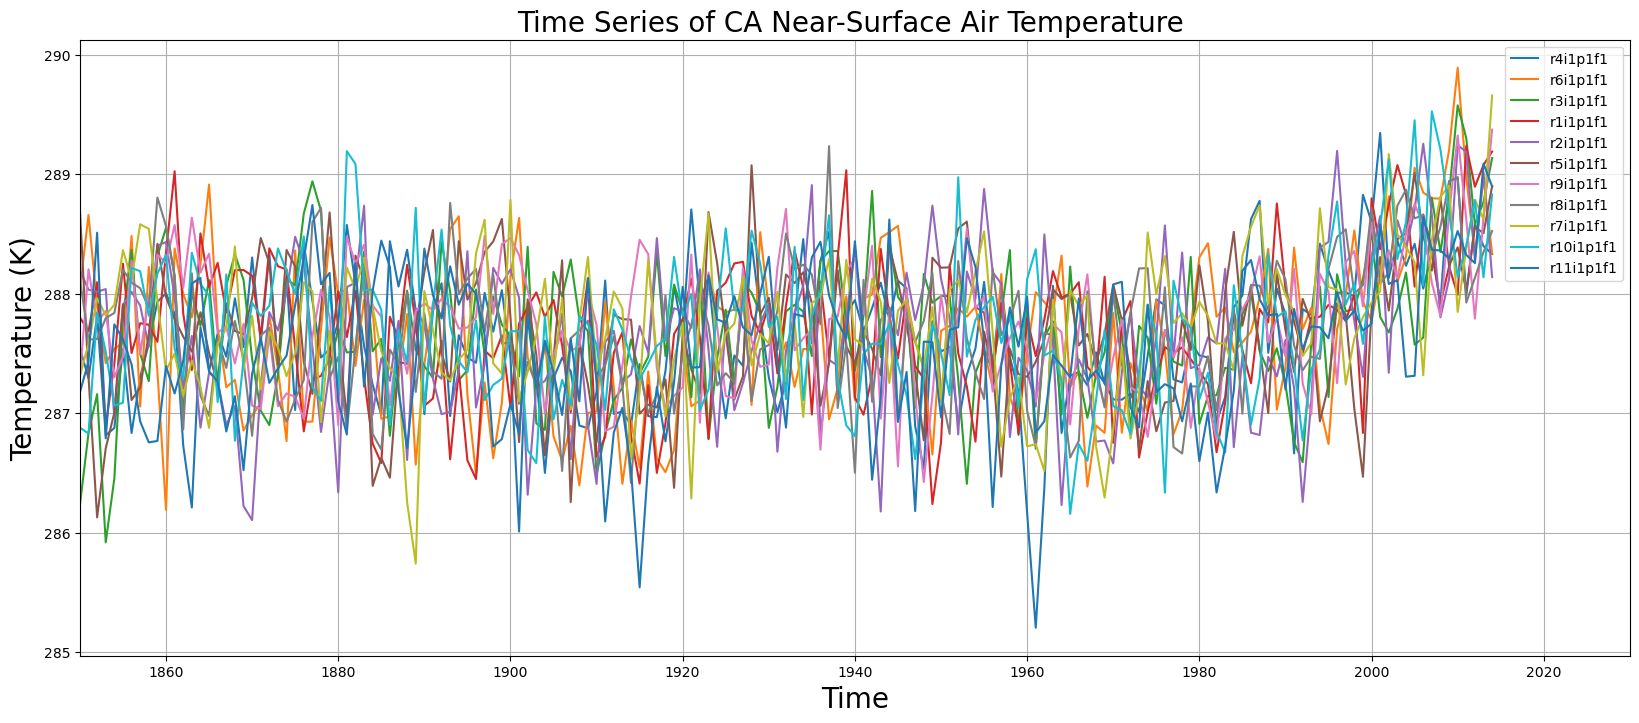

In [26]:
# Set up a blank figure for plotting
fig, ax = plt.subplots(figsize = (20, 8))

# Loop over all ensemble members, plot the time series for each one
for mem in range(nmems):
    ax.plot(dat_wgtmn.year, tas[:, mem], label = str(memnames[mem]))
    
# Set plotting parameters
ax.set_title("Time Series of CA Near-Surface Air Temperature", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.legend()
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.set_xlim([1850, 2030])
ax.grid()
plt.show()

Of course, there is an important difference between this plot and those that we made earlier - there are 11 time series now, instead of just one. In cases like this, instead of looking at each individual time series, many times we'll want to plot the _ensemble spread_, or the range of temperatures simulated in the various different ensemble members. This is really helpful to get a sense for how the _internal variability_ (random variations between members) compares with the _forced response_ (the overall background trend that's common across all the members).

There are several different definitions that get used for ensemble spread. Two of the more common ones are:
- The _standard deviation_ across ensemble members

- The distance between the _ensemble maximum_ and _ensemble minimum_

Before starting to make these plots, we have to calculate some ensemble statistics to find out what the ensemble mean, max, min, and standard deviation values are. You can do this in one of two ways:

1) Using the xarray object and calculating statistics across the "member" dimension 

   This is also quite slow! That's because it also performs the step of extracting data from the remote zarr stores, as the code block above did.
   
2) Using the Numpy-formatted `tas` array

   This is my recommended strategy! Because we already grabbed all the data in the step above, we can just calculate statistics using that variable, and avoid doing slow things all over again. However, the Numpy data now doesn't have all the fancy dimension labeling (it's just an array of numbers), so we actually have to tell it which axis to operate along. The `tas` variable has dimension [time x member], so that means we'll need to operate along the second axis (axis = 1 in Python jargon).

In [37]:
# Calculate ensemble mean
#ens_mean = dat_wgtmn.mean(dim = "member").tas.values
ens_mean = np.mean(tas, axis = 1)

# Ensemble spread measures
# max
ens_max = np.max(tas, axis = 1)

# min
ens_min = np.min(tas, axis = 1)

# standard deviation
ens_std = np.std(tas, axis = 1)


Now let's actually make the plot! We'll use the Matplotlib `fill_between` function to create a shaded envelope that has the width of either the standard deviation or the min/max spread, and add that to the plot along with a line for the ensemble mean. 

_Envelope plotting parameters_

When you're plotting a shaded envelope like this one, it's usually a good idea to set the `alpha` parameter to something less than one. Alpha is the _transparency_ of a plot object, and ranges from 1 (fully opaque) to 0 (fully transparent). Here I'm using 0.3, which is big enough to make the object easily visible but small enough that you'll be able to easily see other things plotted on the same axes.

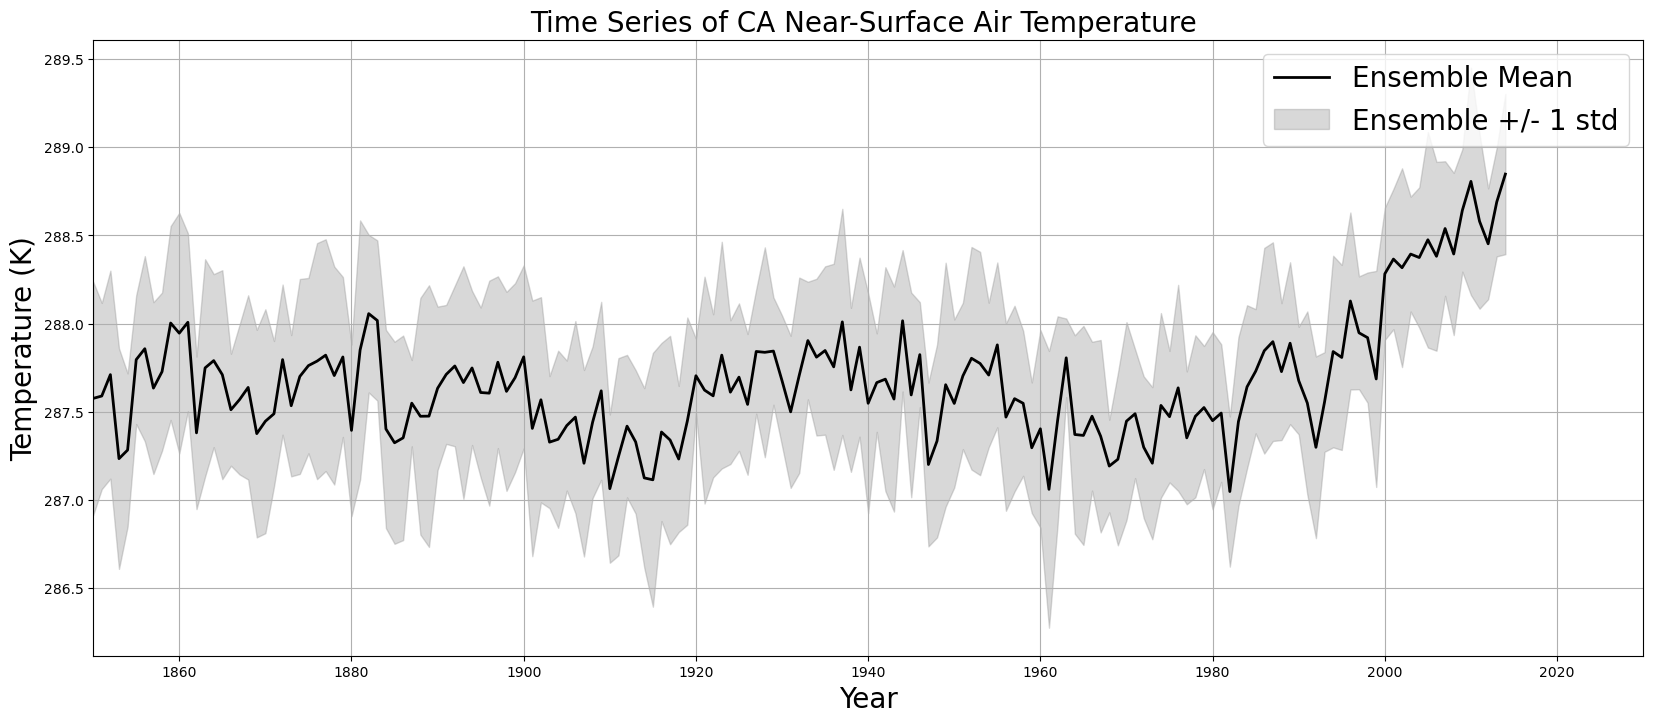

In [38]:
# 1) Ensemble standard deviation

# Set up a blank figure for plotting
fig, ax = plt.subplots(figsize=(20, 8))

# PLot the ensemble mean
ax.plot(dat_wgtmn.year, ens_mean, color = 'k', linewidth = 2, label = "Ensemble Mean")

# Plot the ensemble SPREAD
ax.fill_between(dat_wgtmn.year, ens_mean - ens_std, ens_mean + ens_std, color = 'gray', alpha = 0.3, label="Ensemble +/- 1 std")

# Set plotting parameters
ax.set_title("Time Series of CA Near-Surface Air Temperature ", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.set_xlim([1850, 2030])
ax.legend(fontsize=20)
ax.grid()
plt.show()

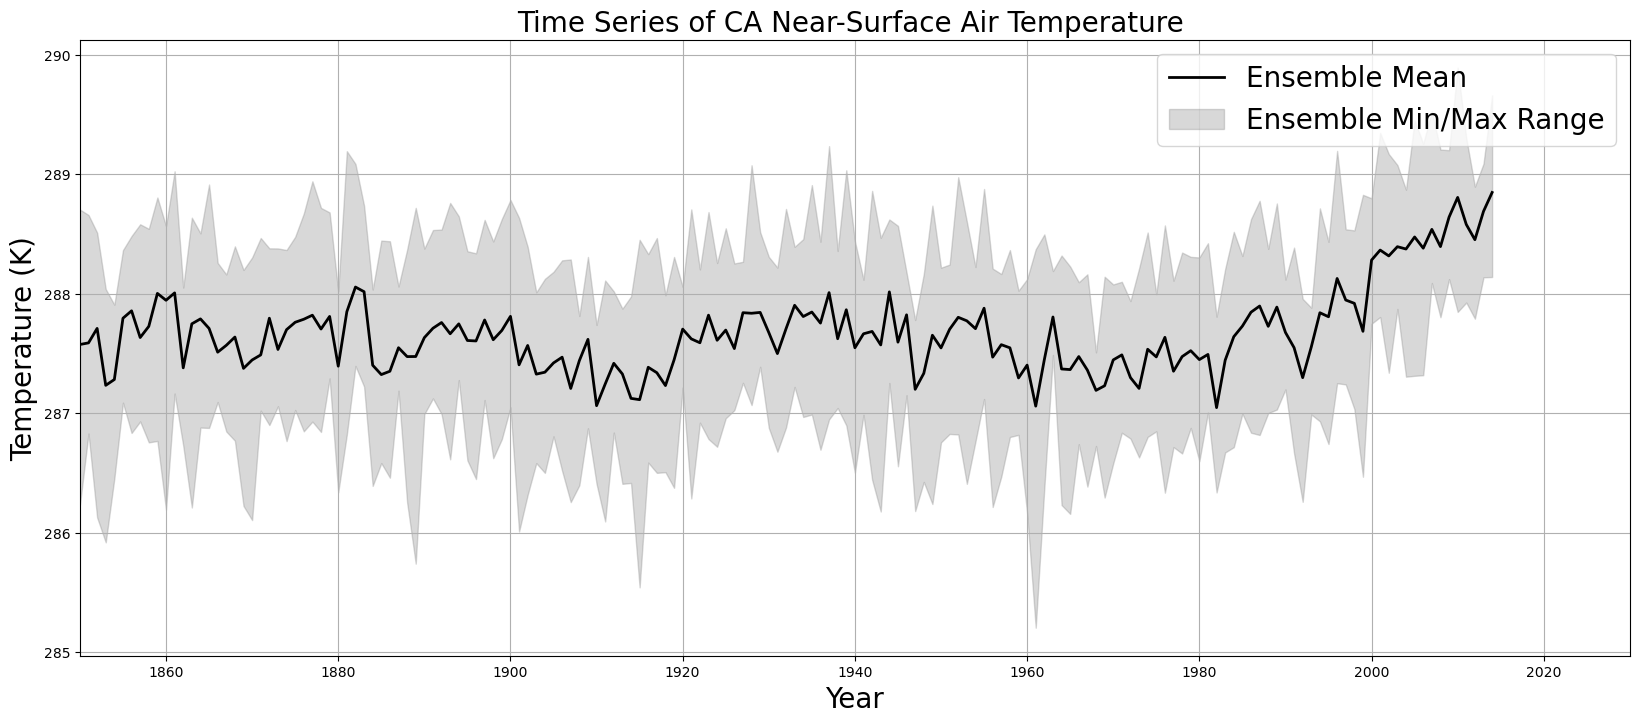

In [39]:
# 1) Ensemble min/max

# Set up a blank figure for plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Loop over all ensemble members, plot the time series for each one
ax.plot(dat_wgtmn.year, ens_mean, color='k', linewidth=2, label="Ensemble Mean")
ax.fill_between(dat_wgtmn.year, ens_min, ens_max, color='gray', alpha=0.3, label="Ensemble Min/Max Range")

# Set plotting parameters
ax.set_title("Time Series of CA Near-Surface Air Temperature ", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.set_xlim([1850, 2030])
ax.legend(fontsize=20)
ax.grid()
plt.show()

And there you have it! Now you can work with large sets of time series information effectively, and make visualizations to display the results.